# Clustering and PCA

In [1]:
# import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

## Contents
***
<a href='#I'>**I. Data Understanding**</a>

<a href='#II'>**II. Data Preparation**</a>

<a href='#III'>**III. Principal Component Analysis**</a>

<a href='#IV'>**IV. Clustering**</a>

<a href='#V'>**V. Visualization**</a>

<a href='#VI'>**VI. Business Insight**</a>
***

### I. Data Understanding<a id='I'></a>

In [2]:
# imoport data into a dataframe
data = pd.read_csv('Country-data.csv')

In [3]:
# lets have a priliminary look at the dataset using pandas profiling library
import pandas_profiling
data.profile_report()

#### Initial thoughts about dataset

1. This dataset is a natural candidate for clustering. It consist of 167 observations and 10 variables.
2. There are neither missing nor duplicate values in the dataset (as evident from the 'Overview' as well as 'Missing values' tab of pandas profile).
3. From the histograms of each variable, it is evident that there are outliers present in the dataset.
4. In 'Correlations' section, we can notice that few variables have high positive and negative correlations amongst them. Hence it is a good usecase for PCA. PCA will help produce orthogonal features without loss of information.
5. `child_mort` has a common base i.e. 1000 live births for every country. `life_expec`, `total_fer`, `income`, and `gdpp` are given per capita. `inflation` is rate of increase of GDP. All these variables are comparable accross countries as they have a common base and hence doesn't require any transformation.
6. `exports`, `health`, and `imports` on the other hand are given as percentage of respective GDPs. These GDPs are different for each country and to process the data further we'll convert these variables to per capita.
7. The scale of variables vary widely and hence it requires Standardization since clustering is sensitive to scale.

### II. Data Preparation<a id='II'></a>

Lets convert variable as a percentage of GDP to variable per capita by multiplying the variable with GDP per capita.

In [4]:
variables = ['imports', 'exports', 'health']
for variable in variables:
    data[variable] = data[variable] * data['gdpp'] / 100

In [5]:
# lets have a look at the data again
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


As we understood that there are outliers in the variables, lets us remove the statistical ones.

In [6]:
# removing (statistical) outliers
# here outlier is defined as <Q1-1.5*IQR and >Q3+1.5*IQR. Q1 and Q3 are 10th and 90th percentile
temp = data
for col in data.columns[1:]:
    Q1 = data[col].quantile(0.10)
    Q3 = data[col].quantile(0.90)
    IQR = Q3 - Q1
    data = data[(data[col] >= Q1 - 1.5*IQR) & (data[col] <= Q3 + 1.5*IQR)]

data.shape

(155, 10)

Countries that were at the extreme with respect to any one variable is taken as outlier. These countries may also require help but will distort the clustering, so we'll keep them seperate and analyse at the time of deriving business insigths.

In [7]:
# outliers
outliers = list(set(list(temp.index))-set(list(data.index)))
outliers = temp.iloc[outliers].reset_index(drop=True)

Lets standardize the data before proceeding with PCA and Clustering as the result is sensitive to scale.

In [8]:
# rescaling
scaled_data = data[data.columns[1:]]

# instantiate
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit_transform
scaled_data = scaler.fit_transform(scaled_data)

scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = data.columns[1:]
scaled_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.252011,-0.690681,-0.576992,-0.740567,-0.869974,0.312763,-1.567235,1.854717,-0.716311
1,-0.582286,-0.515039,-0.401735,-0.407713,-0.302018,-0.403744,0.726091,-0.898542,-0.448484
2,-0.315616,-0.423593,-0.465263,-0.520097,-0.099275,1.276790,0.748910,-0.079827,-0.420467
3,1.969779,-0.345183,-0.531477,-0.498295,-0.577122,2.188708,-1.122261,2.079204,-0.490888
4,-0.739298,0.194975,-0.038961,0.586972,0.323962,-0.845228,0.783139,-0.581620,0.165618


Before proceeding with PCA lets have a look at the correlation between variables to understand effect of PCA better.

<Figure size 720x576 with 0 Axes>

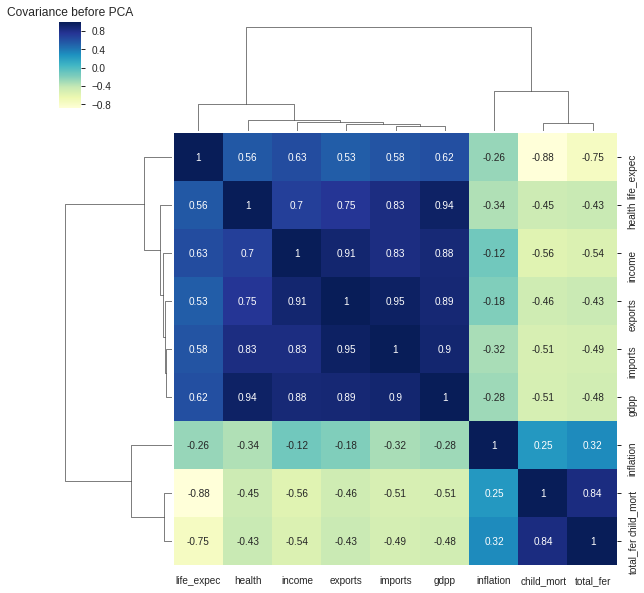

In [9]:
%matplotlib inline
fig = plt.figure(figsize = (10,8))
sns.clustermap(scaled_data.corr(), cmap='YlGnBu', annot = True)
plt.title('Covariance before PCA')
plt.show()

We can clearly notice that there is high multicolinearity in the dataset. Lets apply PCA.

### III. Principal Component Analysis<a id='III'></a>

In [10]:
# importing the PCA module
from sklearn.decomposition import PCA

# initiate PCA
pca = PCA(svd_solver='randomized', random_state=100)

In [11]:
#Doing the PCA on the scaled data
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
    svd_solver='randomized', tol=0.0, whiten=False)

lets have a look at the composition (linear transformation) that make up each principal component with respect to original features.

In [12]:
pcs_df = pd.DataFrame({'PC1':pca.components_[0], 'PC2':pca.components_[1], 'PC3':pca.components_[2],\
                       'PC4':pca.components_[3], 'PC5':pca.components_[4], 'PC6':pca.components_[5],\
                       'PC7':pca.components_[6], 'PC8':pca.components_[7], 'PC9':pca.components_[8]},\
                      index=data.columns[1:])
pcs_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
child_mort,-0.308900,0.503476,-0.173970,0.058664,0.171983,0.231230,0.730446,0.027217,-0.006981
exports,0.365312,0.314463,0.089755,0.396692,-0.142776,-0.236962,0.063612,-0.709479,0.135263
health,0.352605,0.240488,-0.173099,-0.644607,0.311678,-0.019819,-0.068513,-0.243914,-0.458944
imports,0.379075,0.243521,-0.060707,0.182350,-0.032111,-0.607120,0.139676,0.591484,-0.145170
income,0.369492,0.180300,0.218137,0.349690,-0.112700,0.658000,-0.137448,0.209371,-0.390779
inflation,-0.147265,0.186574,0.924095,-0.194852,0.171663,-0.137260,0.046787,0.031907,0.008326
life_expec,0.331894,-0.386714,0.146973,-0.316816,-0.535470,0.076517,0.570176,-0.025128,0.003186
total_fer,-0.294377,0.497261,-0.060432,-0.257183,-0.714989,-0.034487,-0.283588,0.038964,-0.044032
gdpp,0.384809,0.257591,-0.035244,-0.252306,0.108421,0.250091,-0.107681,0.198866,0.771508


Most of the variance must be explained by the first two PCs. Lets plot the orginal variables as a function of them to visually understand what aspect of data is covered by which PC.

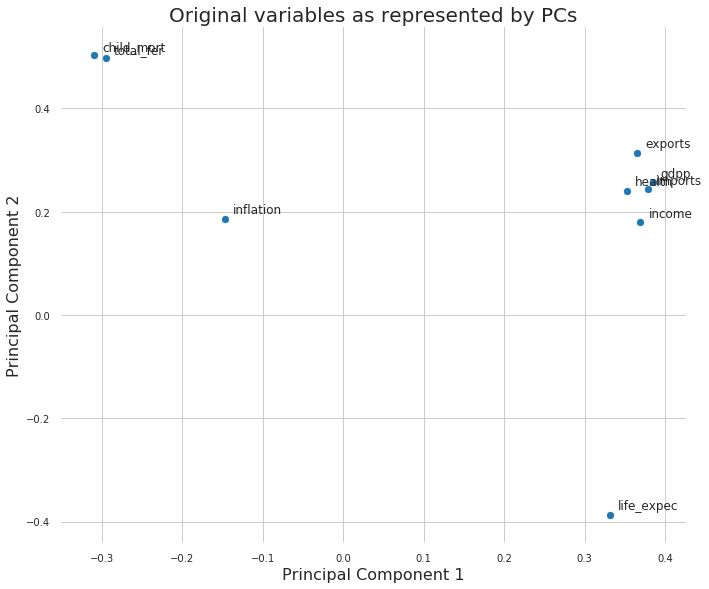

In [13]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize = (10,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
for i, txt in enumerate(pcs_df.index):
    plt.annotate(txt, (pcs_df.PC1[i]+0.01,pcs_df.PC2[i]+0.01), fontsize=12)
plt.tight_layout()
plt.title('Original variables as represented by PCs', fontsize=20)
plt.show()

As we can notice, financial aspect such as gdpp, income, exports etc are covered by the PC1 along with life_expec and health aspect such as child_mort and total_fer are better handled by PC2

Lets have a look at the ratio of variance that is explained by each PC

In [14]:
evr_df = pd.DataFrame({'Percentage of variance explained': pca.explained_variance_ratio_ * 100}, index=pcs_df.columns)
evr_df

,Percentage of variance explained
PC1,65.049208
PC2,15.445147
PC3,10.439389
PC4,3.697056
PC5,2.533025
PC6,1.634264
PC7,0.933143
PC8,0.174853
PC9,0.093915


Making the ***screeplot*** - plotting the cumulative variance against the number of components to identify how many components we should keep.

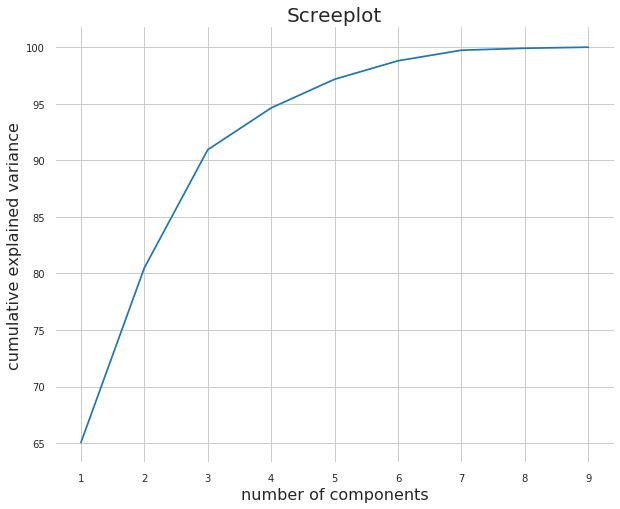

In [15]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize = (10,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('number of components', fontsize=16)
plt.ylabel('cumulative explained variance', fontsize=16)
plt.title('Screeplot', fontsize=20)
plt.xticks(range(9),range(1,10))
plt.show()

As evident from the screeplot, almost 97% of variance is explained by the first `5` variables. 

In [16]:
# using incremental PCA
from sklearn.decomposition import IncrementalPCA

# instantiate
ipca = IncrementalPCA(n_components=5)

In [17]:
# fit and transform scaled_data using Incremental PCA
pca_data = ipca.fit_transform(scaled_data)
pca_data.shape

(155, 5)

Lets analyse the multicolinearity in the resultant pca_data

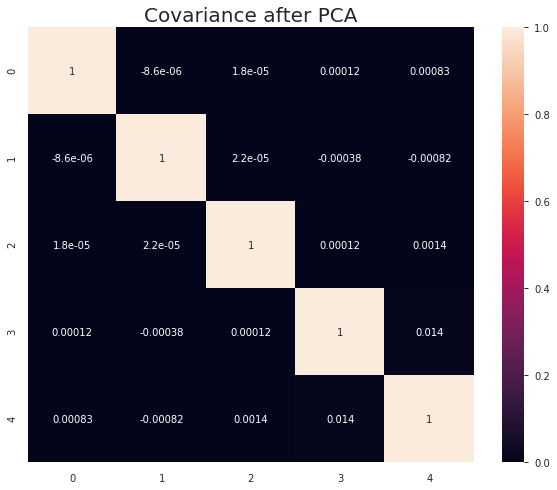

In [18]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(pca_data.transpose())

#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (10,8))
sns.heatmap(corrmat, annot = True)
plt.title('Covariance after PCA', fontsize=20)
plt.show()

In [19]:
# calculating minimum and maximum correlation
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.01431896142041735 , min corr:  -0.0008248431446051528


### IV. Clustering<a id='IV'></a>

Before actually starting the clustering process lets analyse if our data is suitable for clustering and how many clusters should we expect.

Hopkins statistics will tell us if our data is suitable for clustering.

In [20]:
# Hopkins statistics function
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    n = len(X)
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [21]:
pca_data = pd.DataFrame(pca_data)
print('Hopkins statistics for our data: ',round(hopkins(pca_data),3))

Hopkins statistics for our data:  0.802


The hopkins statistic is well above 0.5 and close to 1 hence it is safe to say that our data is suitable for clustering

### KMeans Clustering

Now lets calculate squared sum of errors for elbow-curve analysis to find optimal number of clusters for KMeans

In [22]:
# elbow-curve/SSD
from sklearn.cluster import KMeans

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=100)
    kmeans.fit(pca_data)
    
    ssd.append(kmeans.inertia_)

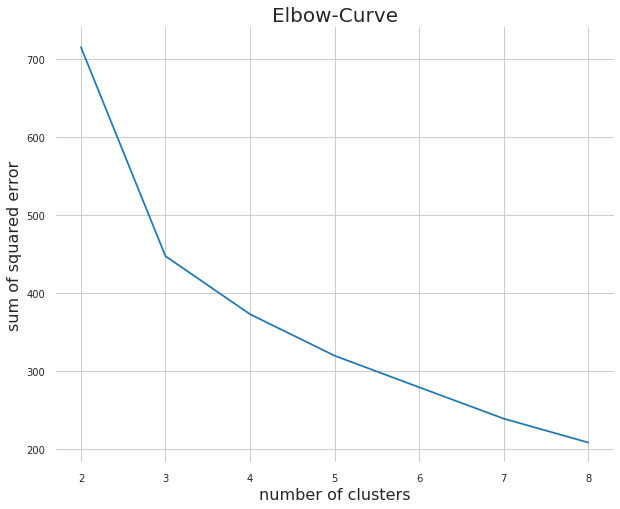

In [23]:
# plot the SSDs for each range_n_clusters
fig = plt.figure(figsize = (10,8))
plt.plot(ssd)
plt.ylabel('sum of squared error', fontsize=16)
plt.xlabel('number of clusters', fontsize=16)
plt.title('Elbow-Curve', fontsize=20)
plt.xticks(range(len(range_n_clusters)),range_n_clusters)
plt.show()

Clearly the elbow is forming at 3 clusters and then onwards the graph is consistent

Also lets perform silhouette analysis for the same range of clusters. Silhouette analysis tells us the extent of cohesion between the clusters formed. A high positive value is desirable.

In [24]:
# silhouette analysis
from sklearn.metrics import silhouette_score

ss = []
for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=100)
    kmeans.fit(pca_data)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(pca_data, cluster_labels)
    ss.append(silhouette_avg)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.4963566502470367
For n_clusters=3, the silhouette score is 0.41723452169520314
For n_clusters=4, the silhouette score is 0.37704524220357233
For n_clusters=5, the silhouette score is 0.37152182062322525
For n_clusters=6, the silhouette score is 0.3529532394790872
For n_clusters=7, the silhouette score is 0.32559541630812117
For n_clusters=8, the silhouette score is 0.33038823345393714


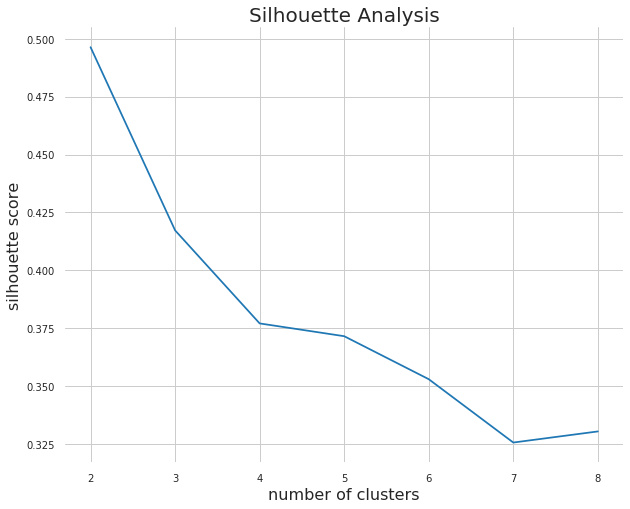

In [25]:
# plot the silhouette score for each range_n_clusters
fig = plt.figure(figsize = (10,8))
plt.plot(ss)
plt.ylabel('silhouette score', fontsize=16)
plt.xlabel('number of clusters', fontsize=16)
plt.title('Silhouette Analysis', fontsize=20)
plt.xticks(range(len(range_n_clusters)),range_n_clusters)
plt.show()

Although silhouette score is low for cluster 3, it is comparable to the maximum silhouette score that is obtained. We'll choose 3 clusters for KMeans clustering.

In [26]:
chosen=3

# final model with k=3
kmeans = KMeans(n_clusters=chosen, max_iter=50, random_state=100)
kmeans.fit(pca_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=100, tol=0.0001, verbose=0)

In [27]:
# assign the label
data['cluster_id'] = kmeans.labels_
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0


Now lets plot behaviour of all variables against the clusters assigned to each observation.

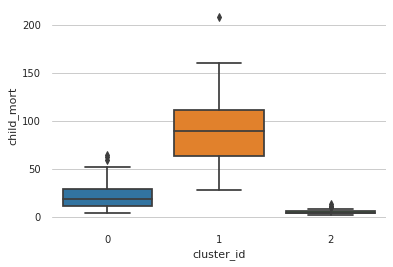

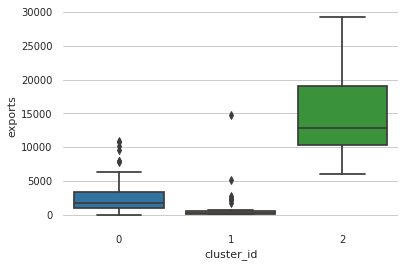

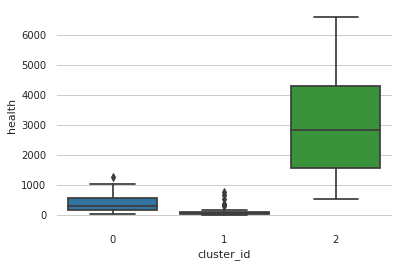

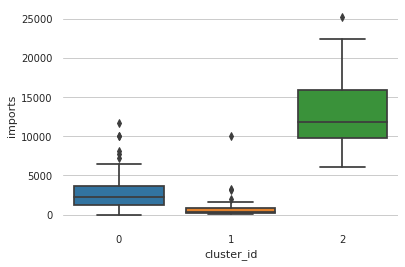

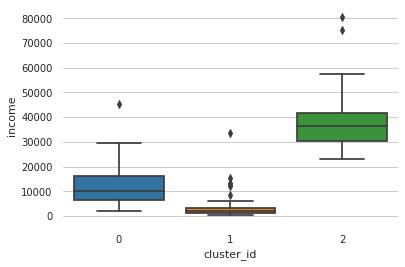

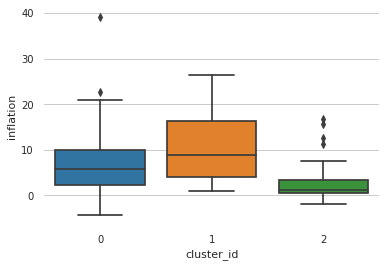

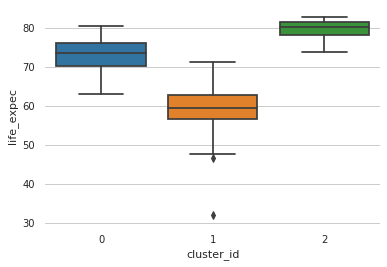

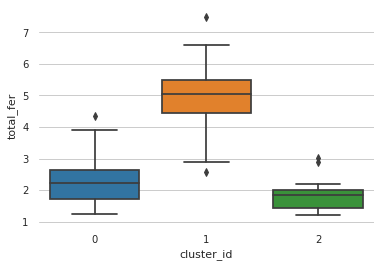

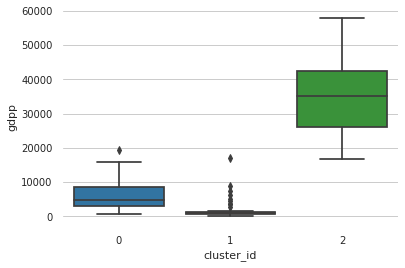

In [28]:
for col in data.columns[1:-1]:
    sns.boxplot(x='cluster_id', y=col, data=data)
    plt.show()

There are clearly 3 distinct clusters with distinct properties.

The cluster of our interest is `cluster 1` as it has the following properties -
1. High child mortality and low life expectancy which indicates lower health standards.
2. Lowest exports, imports, income and gdp per capita which indicates economical instability in the country. Also high inflation only makes it worse.
3. High total fertility results in higher population which adds to the country's problems.

Cluster 1 definitely consists of countries that needs most focus by the NGO. Cluster 2 on the other hand consist of developed and flourishing countries. Cluster 0 lies between 1 and 2 with moderate situations. 

In [29]:
# count of members in each cluster
data['cluster_id'].value_counts()

0    80
1    47
2    28
Name: cluster_id, dtype: int64

### Hierarchical Clustering

Before concluding the final results, lets also perform hierarchical clustering on the dataset.

Lets consider single linkage first.

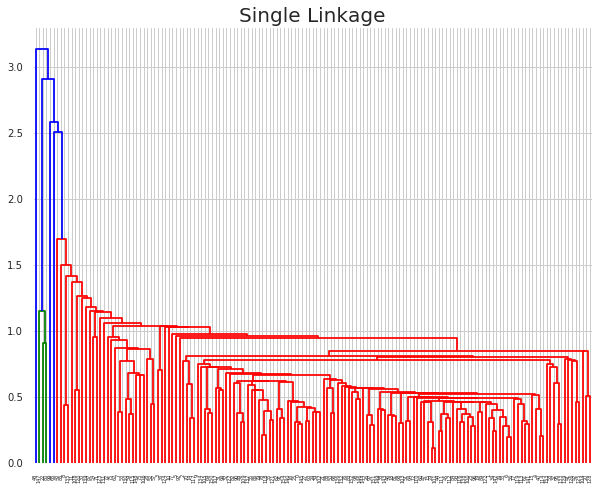

In [30]:
# single linkage
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
mergings = linkage(pca_data, method='single', metric='euclidean')
fig = plt.figure(figsize=(10,8))
dendrogram(mergings)
plt.title('Single Linkage', fontsize=20)
plt.show()

In [31]:
# 3 clusters
from scipy.cluster.hierarchy import cut_tree
cluster_labels = cut_tree(mergings, n_clusters=chosen).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0])

In [32]:
# count of members in each cluster
pd.Series(cluster_labels).value_counts()

0    151
1      3
2      1
dtype: int64

Clusters formed using single linkage are not actionable as most of the data is clustered into 1 cluster. Lets use complete linkage next.

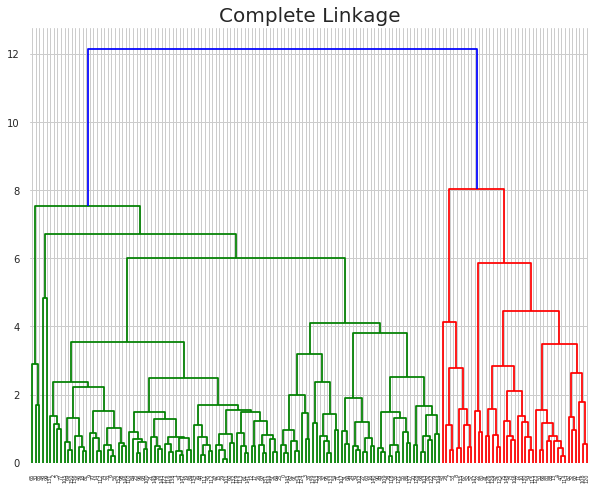

In [33]:
# complete linkage
mergings = linkage(pca_data, method='complete', metric='euclidean')
fig = plt.figure(figsize=(10,8))
dendrogram(mergings)
plt.title('Complete Linkage', fontsize=20)
plt.show()

Complete linkage has certainly produced better results as compared to single linkage.

In [34]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=chosen).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2,
       0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 2, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0])

In [35]:
# count of members in each cluster
pd.Series(cluster_labels).value_counts()

0    114
1     32
2      9
dtype: int64

Hierarchical clustering has shown similar tendancy as KMeans with complete linkage. For further analysis, we'll consider results from KMeans.

### V. Visualization<a id='V'></a>

We have performed the analysis on the PCA data but for business understanding, we need to translate it back to original data. This can be done by visualizing the original data according to clusters formed.

*Note: We will use scaled version of original data so that graphs dont get distorted. Also it may require to run the below cells multiple times if they don't generate desired graphs in single run.*

***Economical aspect***

<IPython.core.display.Javascript object>


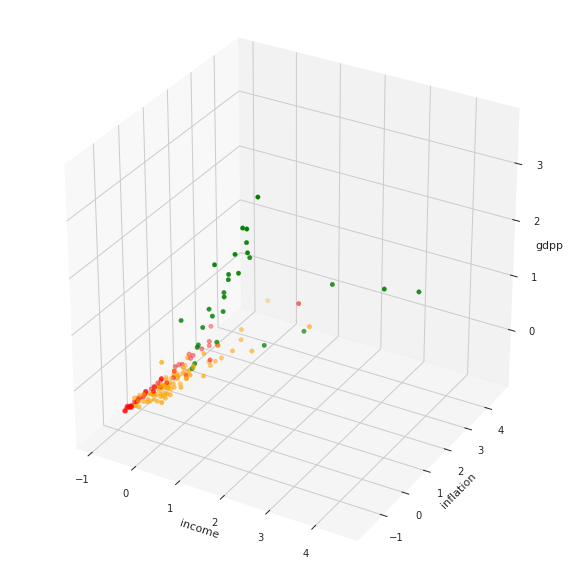

In [55]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
fig.set_label('Economical aspect')
ax = Axes3D(fig)
ax.set_xlabel(scaled_data.columns[4])
ax.set_ylabel(scaled_data.columns[5])
ax.set_zlabel(scaled_data.columns[8])
ax.scatter(scaled_data.iloc[:,4], scaled_data.iloc[:,5], scaled_data.iloc[:,8], c=data['cluster_id'].map({1:'red',0:'orange',2:'green'}))

There are clearly 3 clusters (red, orange, green) representing cluster (1, 0, 2) as created by KMeans.

As the graph of financial aspect (gdpp, inflation, income) dictates, as gdpp increase income per capita increase and inflation decrease. Countries having low gdpp and low income are correctly clustered in red cluster and requires financial aid.

***Health care***

<IPython.core.display.Javascript object>


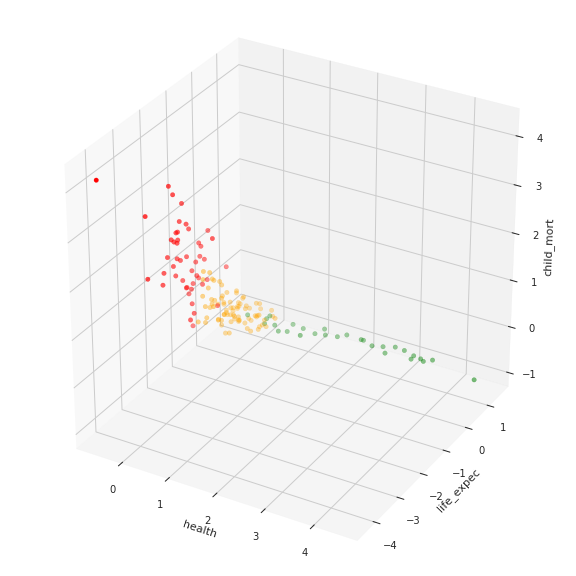

In [56]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
fig.set_label('Health care')
ax = Axes3D(fig)
ax.set_xlabel(scaled_data.columns[2])
ax.set_ylabel(scaled_data.columns[6])
ax.set_zlabel(scaled_data.columns[0])
ax.scatter(scaled_data.iloc[:,2], scaled_data.iloc[:,6], scaled_data.iloc[:,0], c=data['cluster_id'].map({1:'red',0:'orange',2:'green'}))

The pattern for health care is very clear. As the spending on health increases, child mortality decreses and life expectancy increases. The red cluster has high child mortality, low life expectancy as the spending on health is very low. The red cluster requires most health care aid out of the three.

***Economy vs Life expectancy***

<IPython.core.display.Javascript object>


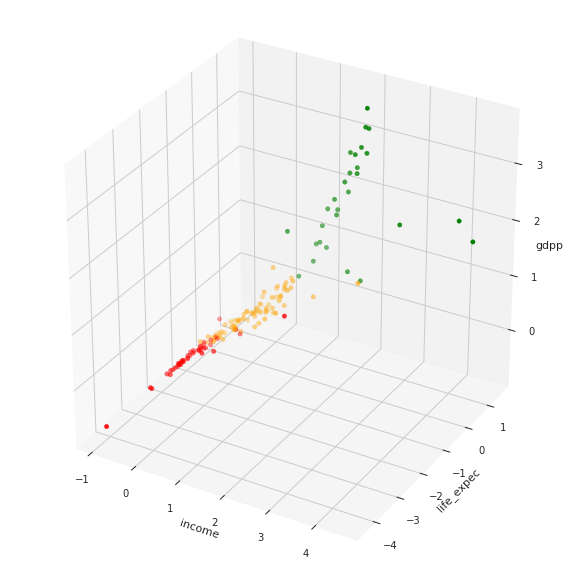

In [57]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
fig.set_label('Economy vs Life expectancy')
ax = Axes3D(fig)
ax.set_xlabel(scaled_data.columns[4])
ax.set_ylabel(scaled_data.columns[6])
ax.set_zlabel(scaled_data.columns[8])
ax.scatter(scaled_data.iloc[:,4], scaled_data.iloc[:,6], scaled_data.iloc[:,8], c=data['cluster_id'].map({1:'red',0:'orange',2:'green'}))

GDP and income per capita have a high impact on life expectancy as our red cluster with low income and gdp has low life expectancy. Again indicating requirement of financial aid. 

***Economy vs Child mortality rate***

<IPython.core.display.Javascript object>


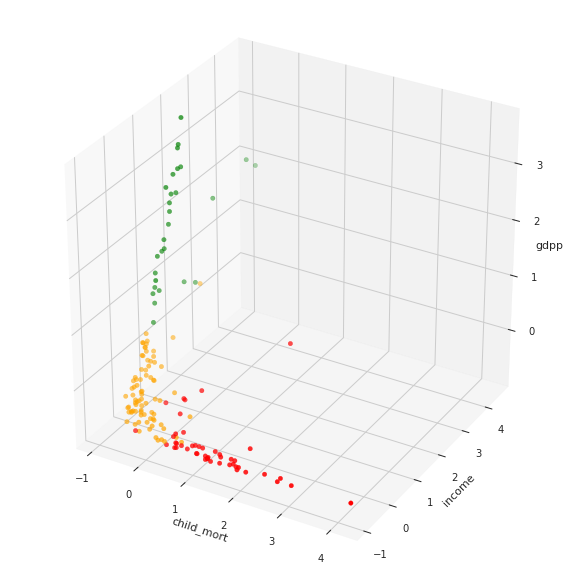

In [58]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
fig.set_label('Economy vs Child mortality rate')
ax = Axes3D(fig)
ax.set_xlabel(scaled_data.columns[0])
ax.set_ylabel(scaled_data.columns[4])
ax.set_zlabel(scaled_data.columns[8])
ax.scatter(scaled_data.iloc[:,0], scaled_data.iloc[:,4], scaled_data.iloc[:,8], c=data['cluster_id'].map({1:'red',0:'orange',2:'green'}))

As expected, gdp and income have similar impact on child mortality. As the economy worsen, the child mortality rate increases.

According to our analysis so far, we can certainly say that there are clusters in the dataset based on the features available and it is the red cluster that requires most attention by the HELP NGO. 

Lets also plot clusters against the Principal Components on which the actual KMeans was executed.

In [40]:
pca_data['cluster_id'] = kmeans.labels_

<IPython.core.display.Javascript object>


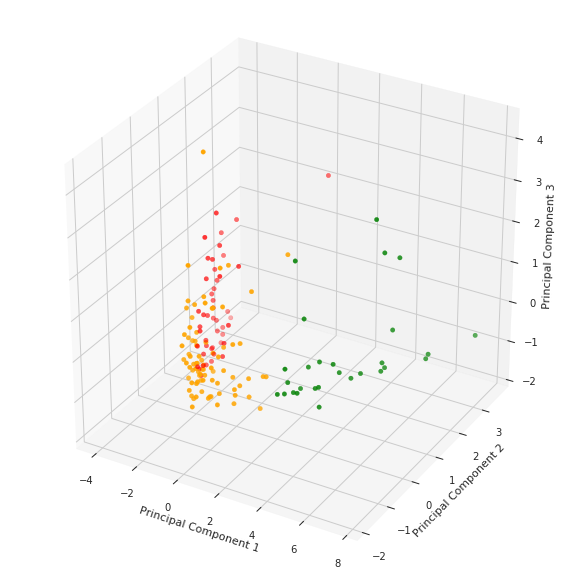

In [59]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
fig.set_label('Principal Components')
ax = Axes3D(fig)
ax.set_xlabel('Principal Component '+str(pca_data.columns[0]+1))
ax.set_ylabel('Principal Component '+str(pca_data.columns[1]+1))
ax.set_zlabel('Principal Component '+str(pca_data.columns[2]+1))
ax.scatter(pca_data.iloc[:,0], pca_data.iloc[:,1], pca_data.iloc[:,2], c=pca_data['cluster_id'].map({1:'red',0:'orange',2:'green'}))

We can clearly observe distinct clusters against the PCs as well and as expected, the variance is in decreasing order from PC1 to PC2 to PC3 as maximum differentiation in clusters is visible with respect to PC1.

Lets also have a look at the data with respect to just first two PCs.

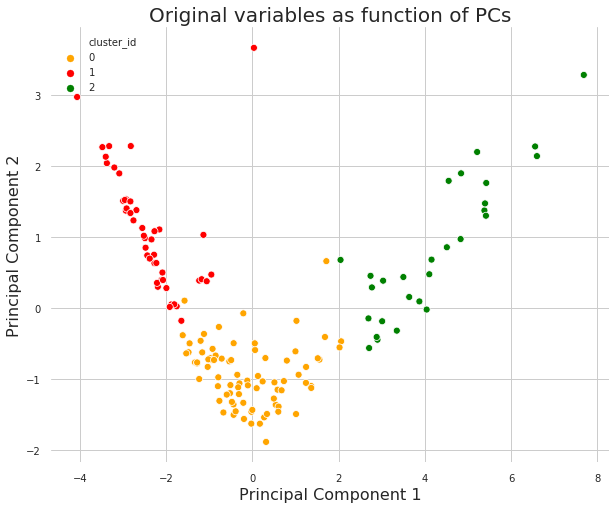

In [42]:
%matplotlib inline
fig = plt.figure(figsize = (10,8))
sns.scatterplot(x=0,y=1,hue='cluster_id',data=pca_data,palette={1:'red',0:'orange',2:'green'})
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.title('Original variables as function of PCs', fontsize=20)
plt.show()

### VI. Business Insight<a id='VI'></a>

From visualizations, we concluded that it is the red cluster i.e. cluster 1 that needs most assistance from the NGO. Now lets observe that specific cluster individually.

In [43]:
target_cluster = data[data['cluster_id']==1]
target_cluster

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.3000,41.9174,248.297,1610,9.440,56.2,5.82,553,1
3,Angola,119.0,2199.1900,100.6050,1514.370,5900,22.400,60.1,6.16,3530,1
17,Benin,111.0,180.4040,31.0780,281.976,1820,0.885,61.8,5.36,758,1
21,Botswana,52.5,2768.6000,527.0500,3257.550,13300,8.920,57.1,2.88,6350,1
25,Burkina Faso,116.0,110.4000,38.7550,170.200,1430,6.810,57.9,5.87,575,1
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.300,57.7,6.26,231,1
28,Cameroon,108.0,290.8200,67.2030,353.700,2660,1.910,57.3,5.11,1310,1
31,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.010,47.5,5.21,446,1
32,Chad,150.0,330.0960,40.6341,390.195,1930,6.390,56.5,6.59,897,1
36,Comoros,88.2,126.8850,34.6819,397.573,1410,3.870,65.9,4.75,769,1


In [44]:
target_cluster.shape

(47, 11)

Currently there are 47 countries in target cluster which is still not an actionable number. Lets further divide it based on socio-economic and health factors.

***Economically backward countries***

First we consider economically backward countries that are performing worse than cluster median.

In [45]:
# first considering income 
economically_backward = target_cluster[target_cluster['income'] < target_cluster['income'].median()]

# next GDP per capita
economically_backward = economically_backward[economically_backward['gdpp'] < economically_backward['gdpp'].median()]

In [46]:
# sorting based on income and gdpp
economically_backward = economically_backward.sort_values(['income', 'gdpp'], ascending=[True, True]).reset_index(drop=True)
economically_backward

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.80,57.5,6.54,334,1
1,Liberia,89.3,62.4570,38.5860,302.802,700,5.47,60.8,5.02,327,1
2,Burundi,93.6,20.6052,26.7960,90.552,764,12.30,57.7,6.26,231,1
3,Niger,123.0,77.2560,17.9568,170.868,814,2.55,58.8,7.49,348,1
4,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.01,47.5,5.21,446,1
5,Mozambique,101.0,131.9850,21.8299,193.578,918,7.64,54.5,5.56,419,1
6,Malawi,90.5,104.6520,30.2481,160.191,1030,12.10,53.1,5.31,459,1
7,Togo,90.3,196.1760,37.3320,279.624,1210,1.18,58.7,4.87,488,1
8,Sierra Leone,160.0,67.0320,52.2690,137.655,1220,17.20,55.0,5.20,399,1
9,Madagascar,62.2,103.2500,15.5701,177.590,1390,8.79,60.8,4.60,413,1


***Health deprived countries***

This section will consist of health care spending and child mortality rate as they show immediate requirement of aid.

In [47]:
# first considering health 
health_deprived = target_cluster[target_cluster['health'] < target_cluster['health'].median()]

# next child_mort
health_deprived = health_deprived[health_deprived['child_mort'] > health_deprived['child_mort'].median()]

In [48]:
# sorting based on income and gdpp
health_deprived = health_deprived.sort_values(['health', 'child_mort'], ascending=[True, False]).reset_index(drop=True)
health_deprived

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Central African Republic,149.0,52.628,17.7508,118.190,888,2.010,47.5,5.21,446,1
1,Niger,123.0,77.256,17.9568,170.868,814,2.550,58.8,7.49,348,1
2,Mozambique,101.0,131.985,21.8299,193.578,918,7.640,54.5,5.56,419,1
3,"Congo, Dem. Rep.",116.0,137.274,26.4194,165.664,609,20.800,57.5,6.54,334,1
4,Benin,111.0,180.404,31.0780,281.976,1820,0.885,61.8,5.36,758,1
5,Guinea,109.0,196.344,31.9464,279.936,1190,16.100,58.0,5.34,648,1
6,Mali,137.0,161.424,35.2584,248.508,1870,4.370,59.5,6.55,708,1
7,Burkina Faso,116.0,110.400,38.7550,170.200,1430,6.810,57.9,5.87,575,1
8,Chad,150.0,330.096,40.6341,390.195,1930,6.390,56.5,6.59,897,1
9,Haiti,208.0,101.286,45.7442,428.314,1500,5.450,32.1,3.33,662,1


***Life expectancy and spending capacity***

In this section we will consider life expectancy and income as these represent the need for financial aid by individual for improvement  in health conditions.

In [49]:
# first considering life_expec 
low_life_income = target_cluster[target_cluster['life_expec'] < target_cluster['life_expec'].median()]

# next income
low_life_income = low_life_income[low_life_income['income'] < low_life_income['income'].median()]

In [50]:
# sorting based on income and gdpp
low_life_income = low_life_income.sort_values(['life_expec', 'income'], ascending=[True, True]).reset_index(drop=True)
low_life_income

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.01,47.5,5.21,446,1
1,Malawi,90.5,104.6520,30.2481,160.191,1030,12.10,53.1,5.31,459,1
2,Mozambique,101.0,131.9850,21.8299,193.578,918,7.64,54.5,5.56,419,1
3,Sierra Leone,160.0,67.0320,52.2690,137.655,1220,17.20,55.0,5.20,399,1
4,Guinea-Bissau,114.0,81.5030,46.4950,192.544,1390,2.97,55.6,5.05,547,1
5,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.80,57.5,6.54,334,1
6,Burundi,93.6,20.6052,26.7960,90.552,764,12.30,57.7,6.26,231,1
7,Burkina Faso,116.0,110.4000,38.7550,170.200,1430,6.81,57.9,5.87,575,1
8,Guinea,109.0,196.3440,31.9464,279.936,1190,16.10,58.0,5.34,648,1
9,Togo,90.3,196.1760,37.3320,279.624,1210,1.18,58.7,4.87,488,1


Before making the final list lets understand the outliers that we removed before analysis

In [51]:
outliers

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Malta,6.8,32283.00,1825.150,32494.00,28300,3.830,80.3,1.36,21100
1,Venezuela,17.1,3847.50,662.850,2376.00,16500,45.900,75.4,2.47,13500
2,Singapore,2.8,93200.00,1845.360,81084.00,72100,-0.046,82.7,1.15,46600
3,Ireland,4.2,50161.00,4475.530,42125.50,45700,-3.220,80.4,2.05,48700
4,Qatar,9.0,43796.90,1272.430,16731.40,125000,6.980,79.5,2.07,70300
5,Netherlands,4.5,36216.00,5985.700,31990.80,45500,0.848,80.7,1.79,50300
6,Belgium,4.5,33921.60,4750.800,33166.80,41100,1.880,80.0,1.86,44400
7,Nigeria,130.0,589.49,118.131,405.42,5150,104.000,60.5,5.84,2330
8,Norway,3.2,34856.60,8323.440,25023.00,62300,5.950,81.0,1.95,87800
9,Switzerland,4.5,47744.00,8579.000,39761.80,55500,0.317,82.2,1.52,74600


All the countries in this list were considered outliers as they are performing very well in all aspect except `Nigeria` which has high child_mort, inflation and total_fer.

Now lets make the final list by combining economically_backward, health_deprived, and low_life_income countries.

In [52]:
union = list(set(health_deprived.country) | set(low_life_income.country) | set(economically_backward.country))
final_list = data[data.country.isin(union)].reset_index(drop=True)
final_list

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Benin,111.0,180.4040,31.0780,281.976,1820,0.885,61.8,5.36,758,1
1,Burkina Faso,116.0,110.4000,38.7550,170.200,1430,6.810,57.9,5.87,575,1
2,Burundi,93.6,20.6052,26.7960,90.552,764,12.300,57.7,6.26,231,1
3,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.010,47.5,5.21,446,1
4,Chad,150.0,330.0960,40.6341,390.195,1930,6.390,56.5,6.59,897,1
5,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.800,57.5,6.54,334,1
6,Eritrea,55.2,23.0878,12.8212,112.306,1420,11.600,61.7,4.61,482,1
7,Guinea,109.0,196.3440,31.9464,279.936,1190,16.100,58.0,5.34,648,1
8,Guinea-Bissau,114.0,81.5030,46.4950,192.544,1390,2.970,55.6,5.05,547,1
9,Haiti,208.0,101.2860,45.7442,428.314,1500,5.450,32.1,3.33,662,1


Out of these too the most critical countries are as follows:

In [53]:
intersection = list(set(health_deprived.country) & set(low_life_income.country))
critical_list = data[data.country.isin(intersection)].reset_index(drop=True)
critical_list

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Burkina Faso,116.0,110.400,38.7550,170.200,1430,6.81,57.9,5.87,575,1
1,Central African Republic,149.0,52.628,17.7508,118.190,888,2.01,47.5,5.21,446,1
2,"Congo, Dem. Rep.",116.0,137.274,26.4194,165.664,609,20.80,57.5,6.54,334,1
3,Guinea,109.0,196.344,31.9464,279.936,1190,16.10,58.0,5.34,648,1
4,Guinea-Bissau,114.0,81.503,46.4950,192.544,1390,2.97,55.6,5.05,547,1
5,Mozambique,101.0,131.985,21.8299,193.578,918,7.64,54.5,5.56,419,1
6,Niger,123.0,77.256,17.9568,170.868,814,2.55,58.8,7.49,348,1


In [54]:
critical_list.country

0                Burkina Faso
1    Central African Republic
2            Congo, Dem. Rep.
3                      Guinea
4               Guinea-Bissau
5                  Mozambique
6                       Niger
Name: country, dtype: object

### Conclusion

The following countries face high child mortality, low exports and imorts, low income per capita, low spending on health per capita, high inflation, low life expectancy, high fertility (and hence population) and low GDP per capita:
1.                        Benin
2.                 Burkina Faso
3.                      Burundi
4.     Central African Republic
5.                         Chad
6.             Congo, Dem. Rep.
7.                      Eritrea
8.                       Guinea
9.                Guinea-Bissau
10.                        Haiti
11.                     Liberia
12.                  Madagascar
13.                      Malawi
14.                        Mali
15.                  Mozambique
16.                       Niger
17.                Sierra Leone
18.                        Togo

Out of which the following countries are in critical stage and requires most attention:
1.                     Burundi
2.    Central African Republic
3.            Congo, Dem. Rep.
4.                      Malawi
5.                  Mozambique
6.                       Niger
7.                Sierra Leone
8.                        Togo